In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
!pip install -q git+https://github.com/Damowerko/ese2000-dynamical-systems.git

In [2]:
from pathlib import Path

import matplotlib.style
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import torch
from tqdm.notebook import trange

from ese2000_dynamical.config import Config
from ese2000_dynamical.track import load_track, Track
from ese2000_dynamical.simulator import Simulator, dynamics_ca

# matplotlib settings
matplotlib.style.use("seaborn-v0_8-colorblind")
plt.rcParams["figure.dpi"] = 150

data_path = Path("data")
figure_path = Path("figures")

# device for pytorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Which expert trajectory we will use for plotting
expert_idx = 5

t = np.arange(0, Config.duration, Config.time_step)
x_experts = np.load(data_path / "states.npy")
u_experts = np.load(data_path / "inputs.npy")
track = load_track(data_path / "track.npz")
x_expert = x_experts[expert_idx]
u_expert = u_experts[expert_idx]
track = load_track(data_path / "track.npz")

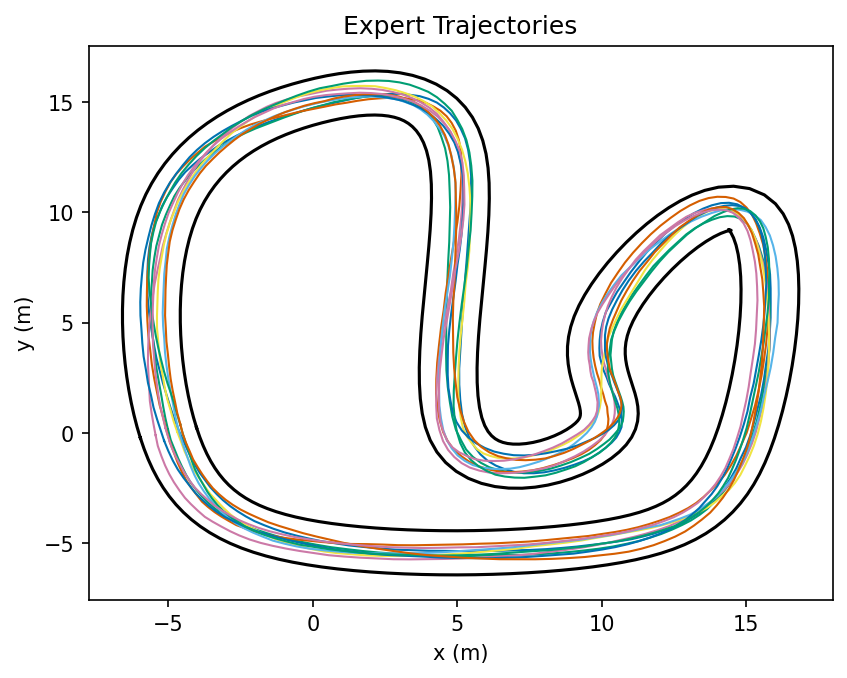

In [4]:
plt.figure()
track.plot(plt.gca())
plt.title("Expert Trajectories")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.plot(x_experts[..., 0].T, x_experts[..., 1].T, "-", linewidth=1.0)
plt.savefig(figure_path / "expert_trajectories.pdf", bbox_inches="tight")

# Constant Acceleration Model

Let's try see how well the constant acceleration model reflects the behaviour above.

In [5]:
A_ca, B_ca = dynamics_ca(Config.time_step)

# compute the single step error
x_predicted = x_expert @ A_ca.T + u_expert @ B_ca.T
mse = np.linalg.norm(x_expert[1:] - x_predicted[:-1], axis=1).mean()
print(f"Single Step MSE: {mse:.4f}")


Single Step MSE: 0.0526


Keep in mind that this is merely the error that we would get from predicting one step forward. However, these errors accumulate over time, so that the final state of the system would be very different.

Cumulative MSE: 83.0640


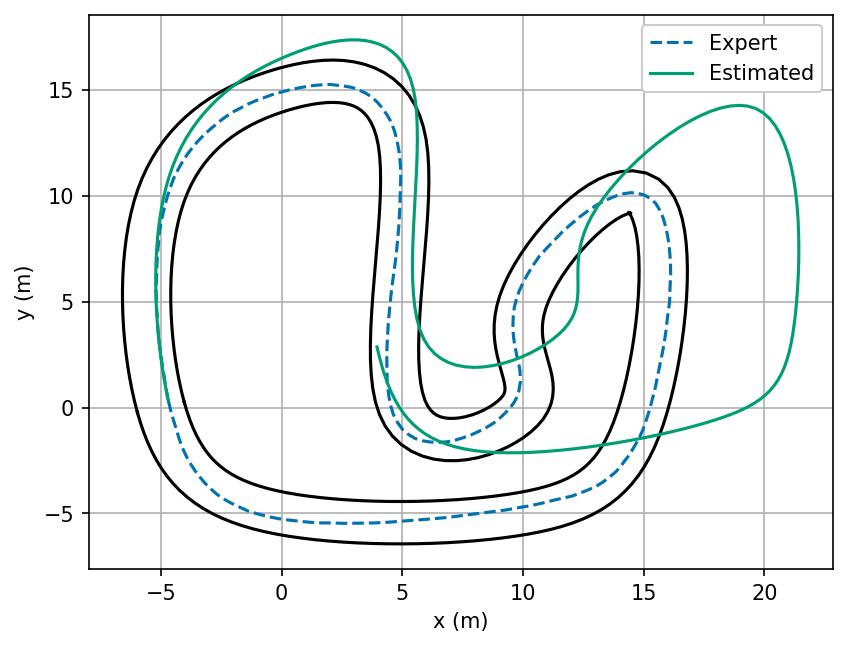

In [6]:
# use the same starting point as the expert
x_ca = np.zeros((len(t), A_ca.shape[0]))
x_ca[0] = x_expert[0]

# simulate the trajectory
for i in range(len(t) - 1):
    x_ca[i + 1] = x_ca[i] @ A_ca.T + u_expert[i] @ B_ca.T

mse = np.linalg.norm(x_expert - x_ca)
print(f"Cumulative MSE: {mse:.4f}")

def plot_vs_expert(x, x_label: str, x_expert, track: Track):
    """
    Plot a given trajectory and expert trajectory on the same plot.
    
    Args:
        x: The trajectory to plot.
        x_label: The label for the trajectory.
        x_expert: The expert trajectory.
        track: The track to plot.
    """

    plt.figure()
    track.plot()
    plt.grid(True)
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.plot(x_expert[:, 0], x_expert[:, 1], "--", label="Expert")
    plt.plot(x[:, 0], x[:, 1], "-", label=x_label)
    plt.legend(loc="upper right", framealpha=1.0)

plot_vs_expert(x_ca, "Estimated", x_expert, track)
plt.savefig(figure_path / "ca.pdf")

# Learning a linear model
Ok. We probably are expecting too much from a constant acceleration model. Can we find a better model from data?

In [8]:
n_steps = 10000
lr = 1e-3
l1_reg = 1e-3
l2_reg = 1e-3

x_tensor = torch.from_numpy(x_experts).to(device).float()
u_tensor = torch.from_numpy(u_experts).to(device).float()

n_states = x_tensor.shape[-1]
n_inputs = u_tensor.shape[-1]

A_learnt = torch.zeros(n_states, n_states, device=device, requires_grad=True)
B_learnt = torch.zeros(n_states, n_inputs, device=device, requires_grad=True)

optimizer = torch.optim.Adam([A_learnt, B_learnt], lr=lr, weight_decay=l2_reg)
pbar = trange(n_steps)
for i in pbar:
    optimizer.zero_grad()
    x_pred = x_tensor[:, :-1] @ A_learnt.T + u_tensor[:, :-1] @ B_learnt.T
    loss = (x_tensor[:, 1:] - x_pred).pow(2).mean()
    loss += l1_reg * (A_learnt.abs().sum() + B_learnt.abs().sum())
    loss.backward()
    optimizer.step()
    pbar.set_postfix(loss=loss.item())

np.save(data_path / "A.npy", A_learnt.detach().cpu().numpy())
np.save(data_path / "B.npy", B_learnt.detach().cpu().numpy())


  0%|          | 0/10000 [00:00<?, ?it/s]

Make sure you save the model. Print out the $A$ and $B$ matrices that you learnt.

In [9]:
A_learnt = np.load(data_path / "A.npy")
B_learnt = np.load(data_path / "B.npy")
print("A =")
print(np.array2string(A_learnt, precision=2, suppress_small=True))
print("B =")
print(np.array2string(B_learnt, precision=2, suppress_small=True))


A =
[[ 1.    0.    0.05 -0.  ]
 [ 0.    1.    0.    0.05]
 [-0.    0.    0.99  0.  ]
 [ 0.   -0.   -0.    0.99]]
B =
[[ 0.    0.  ]
 [ 0.    0.  ]
 [ 0.05 -0.  ]
 [-0.    0.05]]


Like with the CA model, let's compute the single step squared error.

In [11]:
# compute the single step error
x_predicted = x_expert @ A_learnt.T + u_expert @ B_learnt.T
mse = np.linalg.norm(x_expert[1:] - x_predicted[:-1], axis=1)
print(f"Single Step MSE: {mse.mean():.4f}")


Single Step MSE: 0.0287


We should expect a lower MSE than with the constant acceleration model. Again though, any errors will accumulate over time.

Cumulative MSE: 13.2273


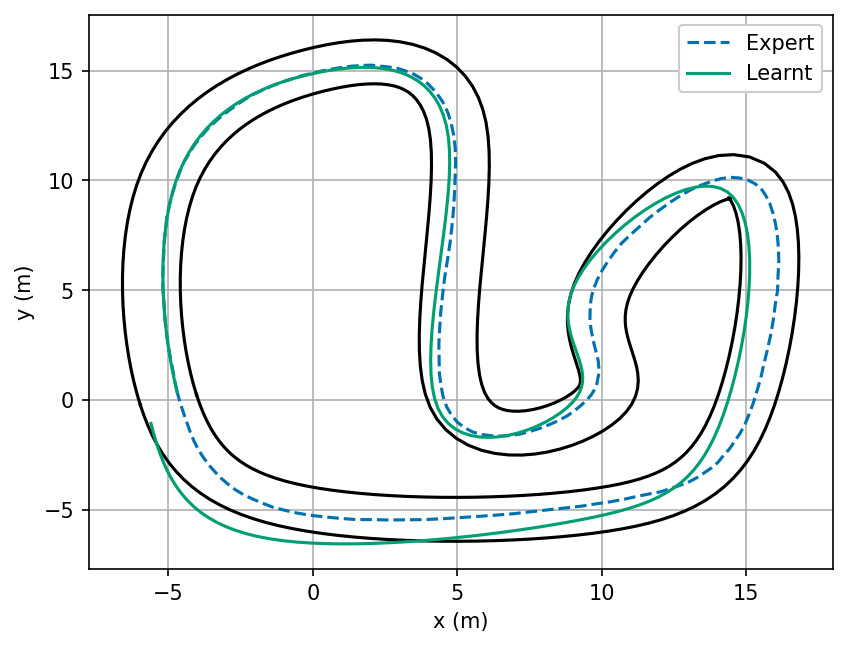

In [14]:
# use the same starting point as the expert
t = np.arange(0, Config.duration, Config.time_step)
x_learnt = np.zeros((len(t), A_learnt.shape[0]))
x_learnt[0] = x_expert[0]

# simulate the trajectory
for i in range(len(t) - 1):
    x_learnt[i + 1] = (
        x_learnt[i] @ A_learnt.T + u_expert[i % len(u_expert)] @ B_learnt.T
    )
mse = np.linalg.norm(x_expert - x_learnt)
print(f"Cumulative MSE: {mse:.4f}")

plot_vs_expert(x_learnt, "Learnt", x_expert, track)
plt.savefig(figure_path / "learnt.pdf")

This time around our final position is much closer to the expert trajectory but still not perfect. We would deviate further if we did more than 1 lap.

# Control without feedback

In [15]:
import torch

torch.set_float32_matmul_precision("medium")


def rollout(A, B, u, x0):
    """
    Integrate the system dynamics to predict the trajectory.

    Args:
        A: (4, 4) The state transition matrix.
        B: (4, 2) The input matrix.
        u: (T, 2) The control inputs.
        x0: (4,) The initial state.
    """
    x = torch.zeros((len(u) + 1, A.shape[0]), device=A.device)
    x[0] = x0
    for i in range(len(u)):
        x[i + 1] = x[i] @ A.T + u[i] @ B.T
    # return the predicted trajectory
    return x[1:]


In [18]:
with device:
    A = torch.from_numpy(A_learnt).to(device).float()
    B = torch.from_numpy(B_learnt).to(device).float()
    x0 = torch.tensor(x_expert[0]).float()
    x_ref = torch.tensor(x_expert[1:]).float()
    u_naive = torch.zeros(len(x_ref), 2, requires_grad=True).float()
    optimizer = torch.optim.Adam([u_naive], lr=1.0)

pbar = trange(1000)
for _ in pbar:
    optimizer.zero_grad()
    x_pred = rollout(A, B, u_naive, x0)
    # penalize the difference between the predicted and reference trajectory
    loss = (x_pred - x_ref).pow(2).mean()
    # add loss to progress bar
    pbar.set_postfix(loss=loss.item())
    loss.backward()
    optimizer.step()


  0%|          | 0/1000 [00:00<?, ?it/s]

## Testing our controller

To test your controller we implement a class called `Simulator` for you. By iteratively calling `step` you can simulate on the ground truth system.
`step` takes two arguments:
* an array of length 4 with the current state of the system,
* and an array of length 2 with the control inputs to apply.

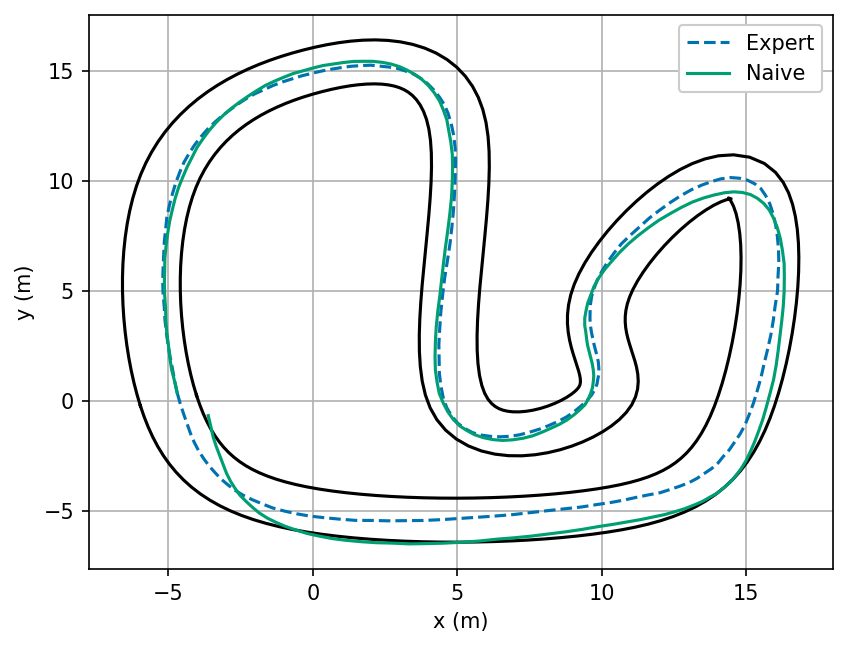

In [20]:
simulator = Simulator()
t = np.arange(0, Config.duration, Config.time_step)
x_naive = np.zeros_like(x_expert)
# use the starting point as the initial estimate
x_naive[0] = x_expert[0]
for i in range(len(t) - 1):
    x_naive[i + 1] = simulator.step(x_naive[i], u_naive[i].detach().cpu().numpy())

plot_vs_expert(x_naive, "Naive", x_expert, track)
plt.savefig(figure_path / "naive.pdf")

# MPC Control

Above we repeated the same inputs as the expert, but our trajectory was not the same.
For real systems, it would be impossible to replicate the same conditions. Any errors in the inputs or noise in the system accumulates over time.
However, we can use the matrices $A$ and $B$ we learnt above, to implement a _controller_ that is robust to noise.

In [24]:
def calculate_reference(
    state: npt.NDArray[np.floating],
    x_expert: npt.NDArray[np.floating],
    u_expert: npt.NDArray[np.floating],
    horizon: int,
):
    # find the nearest point in the expert trajectory based on position
    nearest_idx = np.argmin(np.linalg.norm(x_expert[:, :2] - state[:2], axis=1))
    ref_idx = np.arange(nearest_idx + 1, nearest_idx + horizon + 1) % len(x_expert)
    return x_expert[ref_idx], u_expert[ref_idx]


def mpc_controller(
    state: npt.NDArray[np.floating],
    state_matrix: npt.NDArray[np.floating],
    input_matrix: npt.NDArray[np.floating],
    x_ref: npt.NDArray[np.floating],
    u_ref: npt.NDArray[np.floating],
):
    """MPC controller.

    Args:
        x: (4,) array with current state
        A: (4,4) array with state matrix
        B: (4,2) array with input matrix

    Returns:
        u: (M,) array with control input
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    A = torch.from_numpy(state_matrix).to(device)
    B = torch.from_numpy(input_matrix).to(device)

    x_ref_tensor = torch.tensor(x_ref, device=device).float()
    u_ref_tensor = torch.tensor(u_ref, device=device).float()

    # initialize x and u to the reference trajectory
    x0 = torch.tensor(state, device=device).float()
    u = u_ref_tensor.clone().requires_grad_(True)
    optimizer = torch.optim.Adam([u], lr=1.0)

    for _ in range(20):
        optimizer.zero_grad()
        x = rollout(A, B, u, x0)
        loss = (x - x_ref_tensor).pow(2).mean()
        loss.backward()
        optimizer.step()
    return u.detach().cpu().numpy()


In [25]:
# simulate the trajectory
n_laps = 3
t = np.arange(0, Config.duration * n_laps, Config.time_step)
x_mpc = np.zeros((len(t), A_learnt.shape[0]))
# use the same starting point as the expert
x_mpc[0] = x_expert[0]

for i in trange(len(t) - 1):
    x_ref, u_ref = calculate_reference(x_mpc[i], x_expert, u_expert, horizon=10)
    u_mpc = mpc_controller(x_mpc[i], A_learnt, B_learnt, x_ref, u_ref)
    x_mpc[i + 1] = simulator.step(x_mpc[i], u_mpc[0])

  0%|          | 0/599 [00:00<?, ?it/s]

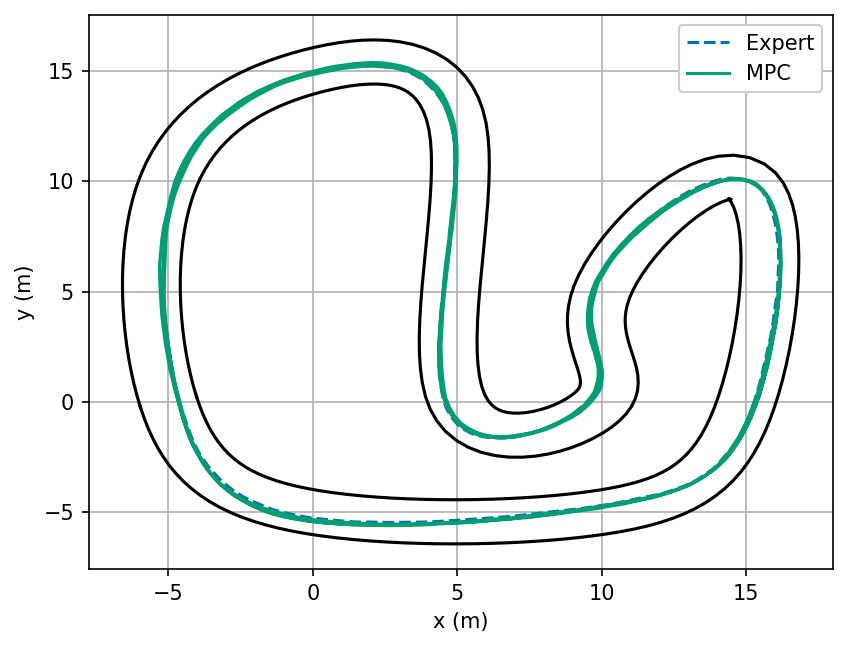

In [26]:
plot_vs_expert(x_mpc, "MPC", x_expert, track)
plt.savefig(figure_path / "mpc.pdf")

In [27]:
from matplotlib.animation import FuncAnimation
from IPython.core.display import HTML

# get the color palette
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

trail_length = 10

plt.figure()
track.plot(plt.gca())
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.plot(x_expert[:, 0], x_expert[:, 1], "--", label="Expert")
trail = plt.plot([], [], "-", c=colors[1], label="MPC")[0]
current_position = plt.plot([], [], "o", c=colors[1])[0]
plt.legend(loc="upper right", framealpha=1.0)


def animate(i: int):
    trail_idx = slice(max(i - trail_length, 0), i + 1)
    trail.set_data(x_mpc[trail_idx, 0], x_mpc[trail_idx, 1])
    current_position.set_data([x_mpc[i, 0]], [x_mpc[i, 1]])
    return trail, current_position


# html5 video
ani = FuncAnimation(plt.gcf(), animate, frames=len(t), interval=int(1000 * Config.time_step), blit=True)
display(HTML(ani.to_html5_video()))
plt.close()
